# Imports

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, f1_score
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from transformers import RobertaModel, RobertaTokenizer
import logging
from transformers import BertModel, BertConfig
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, log_loss
from torch.nn import CrossEntropyLoss
import numpy as np
from copy import deepcopy
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AutoTokenizerfrom transformers import pipeline


In [210]:
!unzip /content/bert_aug.zip

Archive:  /content/bert_aug.zip
   creating: content/turbo_bert/
  inflating: content/turbo_bert/tokenizer_config.json  
  inflating: content/turbo_bert/vocab.txt  
  inflating: content/turbo_bert/model.safetensors  
  inflating: content/turbo_bert/training_args.bin  
  inflating: content/turbo_bert/special_tokens_map.json  
  inflating: content/turbo_bert/config.json  
  inflating: content/turbo_bert/tokenizer.json  


In [215]:
!pip freeze | grep transformers

sentence-transformers==3.2.1
transformers==4.46.2


In [212]:
pipe = pipeline(task='text-classification', model='/content/content/turbo_bert')

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [218]:
pipe('За участие в конференции в г. Майкоп по договору 88.367840-ДВ от 11 апреля 2026')

[{'label': 'SERVICE', 'score': 0.8498392105102539}]

In [206]:
pd.read_csv('/content/test_data.tsv'б )

,Unnamed: 0,0,1,2,3
0,0,1,07.11.2024,40500.00,За тур.поездку по договору №001 от 27.01.2023г
1,1,2,07.11.2024,"32600,00",За оказание услуг по договору №53Б-02746 от 23...
2,2,3,07.11.2024,4710-00,Оплата штрафа
3,3,4,07.11.2024,30900-00,Лечение по договору №Д-00359/24 от 08.03.2025
4,4,5,07.11.2024,13200.00,Оплата основного долга за период с 16.12.2024г...
...,...,...,...,...,...
95,95,96,07.11.2024,"2590000,00",Паевой взнос в жилищно-строительный кооператив...
96,96,97,07.11.2024,"132000000,00",По предвариельному договору №42-02124 от 27.07...
97,97,98,07.11.2024,12200-00,Оплата по сч. 0998 от 05 сентября 2024 г. за п...
98,98,99,07.11.2024,4430-00,Оплата за Замороженная птица по счету 58597972...


In [202]:
data = pd.read_csv('/content/payments_main.tsv', sep='\t', header=None)
data.head()

,0,1,2,3
0,1,07.11.2024,40500.00,За тур.поездку по договору №001 от 27.01.2023г
1,2,07.11.2024,"32600,00",За оказание услуг по договору №53Б-02746 от 23...
2,3,07.11.2024,4710-00,Оплата штрафа
3,4,07.11.2024,30900-00,Лечение по договору №Д-00359/24 от 08.03.2025
4,5,07.11.2024,13200.00,Оплата основного долга за период с 16.12.2024г...


In [209]:
data.iloc[:100, :].to_csv('test_data.tsv', sep='\t', index=False, header=True)

In [ ]:
data = pd.read_csv('payments_training.tsv', sep='\t', header=None)

data.rename({
    0: 'id',
    1: 'date',
    2: 'sum',
    3: 'text',
    4: 'label'
}, axis=1, inplace=True)

In [ ]:
data.head()

,id,date,sum,text,label
0,1,07.11.2024,15300.00,За участие в конференции в г. Майкоп по догово...,SERVICE
1,2,07.11.2024,"40200,00",За оказание услуг по договору №79-02726В от 01...,SERVICE
2,3,07.11.2024,1440-00,Оплата за Порошок стиральный Ariel Color autom...,NON_FOOD_GOODS
3,4,07.11.2024,240000000-00,Возврат денежных средств по договору займа №04...,LOAN
4,5,07.11.2024,1360000.00,"Оплата Дог №452 от 13/03/2021, согл. Сч 0745-2...",NOT_CLASSIFIED


In [ ]:
new_data = pd.read_csv('/content/augmented.csv')
finaly_df = pd.DataFrame({'text': pd.concat((data['text'], new_data['augmented_texts'], new_data['augmented_texts1'])),
                          'label': pd.concat((data['label'], new_data['category'], new_data['category']))})

In [ ]:
finaly_df.head()

,text,label
0,За участие в конференции в г. Майкоп по догово...,SERVICE
1,За оказание услуг по договору №79-02726В от 01...,SERVICE
2,Оплата за Порошок стиральный Ariel Color autom...,NON_FOOD_GOODS
3,Возврат денежных средств по договору займа №04...,LOAN
4,"Оплата Дог №452 от 13/03/2021, согл. Сч 0745-2...",NOT_CLASSIFIED


In [217]:
finaly_df.iloc[0][0]

<ipython-input-217-1d22b3ec93da>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  finaly_df.iloc[0][0]


'За участие в конференции в г. Майкоп по договору 88.367840-ДВ от 11 апреля 2026'

In [ ]:
data = finaly_df

In [ ]:
# data.drop(['id', 'sum', 'date'], axis=1, inplace=True)

In [ ]:
data['label'].unique()

array(['SERVICE', 'NON_FOOD_GOODS', 'LOAN', 'NOT_CLASSIFIED', 'LEASING',
       'FOOD_GOODS', 'BANK_SERVICE', 'TAX', 'REALE_STATE'], dtype=object)

In [ ]:
label2id = {label: i for i, label in enumerate(set(data['label'].unique()))}
id2label = {i: label for label, i in label2id.items()}


In [ ]:
from collections import Counter
Counter(data['label'])

Counter({'SERVICE': 252,
         'NON_FOOD_GOODS': 287,
         'LOAN': 123,
         'NOT_CLASSIFIED': 107,
         'LEASING': 114,
         'FOOD_GOODS': 265,
         'BANK_SERVICE': 125,
         'TAX': 143,
         'REALE_STATE': 127})

In [ ]:
classes = ['REALE_STATE', 'NOT_CLASSIFIED', 'TAX']


<Axes: >

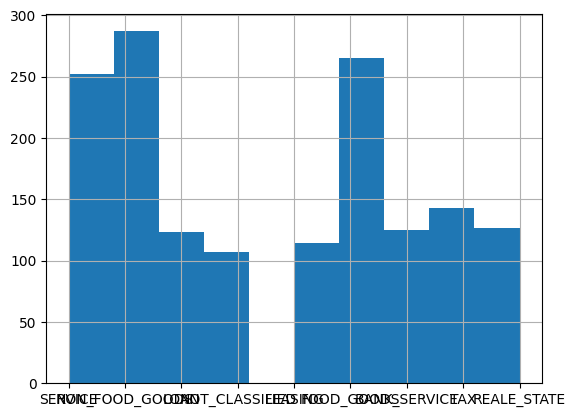

In [ ]:
data['label'].hist()

In [ ]:
# data = pd.DataFrame({
#     'text': ['а', 'fsd', 'ads', 'das'],
#     'label': label2id.keys()
# })

In [ ]:
label2id['NON_FOOD_GOODS']

6

In [ ]:
label2id

{'NOT_CLASSIFIED': 0,
 'TAX': 1,
 'REALE_STATE': 2,
 'BANK_SERVICE': 3,
 'FOOD_GOODS': 4,
 'LEASING': 5,
 'NON_FOOD_GOODS': 6,
 'SERVICE': 7,
 'LOAN': 8}

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
train_new, test_new = train_test_split(data, random_state=42, test_size=0.2)
train = train_new
test_old = test_new

In [ ]:
model_path = "sergeyzh/rubert-tiny-turbo"


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_path, num_labels=9, id2label=id2label, label2id=label2id
)

tokenizer = AutoTokenizer.from_pretrained(model_path, truncation=True, max_length=500)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sergeyzh/rubert-tiny-turbo and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
def preprocess_function(examples):
    tokenized = tokenizer(
        examples["text"],
        truncation=True,
        padding=True,
        max_length=512,
    )
    print()
    tokenized["label"] = list(map(lambda x: label2id[x], examples["label"]))  # Map labels directly
    return tokenized


In [ ]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(train)
train_dataset = train_dataset.map(preprocess_function, batched=True)

old_test_dataset = Dataset.from_pandas(test_old)
old_test_dataset = old_test_dataset.map(preprocess_function, batched=True)


new_test_dataset = Dataset.from_pandas(test_new)
new_test_dataset = new_test_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/1100 [00:00<?, ? examples/s]

Map:   0%|          | 0/276 [00:00<?, ? examples/s]

Map:   0%|          | 0/276 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    "chunk_classification",
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=3e-5,
    num_train_epochs=50,
    weight_decay=0.01,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    label_smoothing_factor=0.05
    # bf16=True

    # push_to_hub=True,
)


model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=9, id2label=id2label,
    label2id=label2id,
    hidden_dropout_prob=0.15,
    attention_probs_dropout_prob=0.15
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sergeyzh/rubert-tiny-turbo and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset[0]['label']

0

In [ ]:
train_dataset[0].keys()

dict_keys(['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
from transformers import TrainerCallback

lang = 'ru'
num_labels = 9

class CustomCallback(TrainerCallback):

    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train@"+lang)
            return control_copy

def compute_metrics(pred):
    global num_labels
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    loss_fct = CrossEntropyLoss()
    logits = torch.tensor(pred.predictions)
    labels = torch.tensor(labels)
    loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
    return {
        'accuracy@'+lang: acc,
        'f1@'+lang: f1,
        'precision@'+lang: precision,
        'recall@'+lang: recall,
        'loss@'+lang: loss,
    }
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=old_test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,

)

<ipython-input-132-30000e6a7913>:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
train_dataloader = trainer.get_train_dataloader()
# output = trainer.evaluation_loop(test_dataloader, 'first')

Counter({6: 62, 4: 54, 7: 38, 3: 32, 8: 26, 5: 23, 2: 16, 0: 14, 1: 11})


(array([14., 11., 16., 32.,  0., 54., 23., 62., 38., 26.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

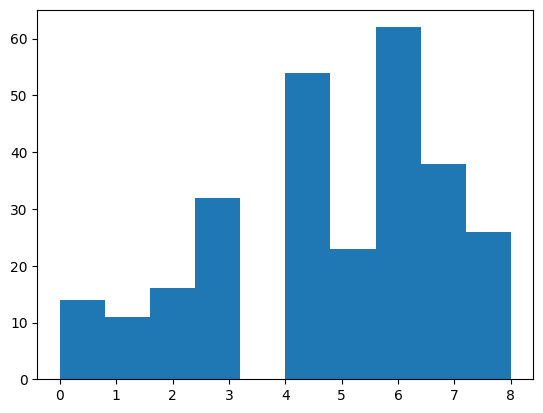

In [ ]:
import matplotlib.pyplot as plt
print(Counter(output.label_ids))
plt.hist(output.label_ids)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy@ru,F1@ru,Precision@ru,Recall@ru,Loss@ru
1,No log,2.085368,0.001900,0.326087,0.135950,0.156345,0.186918,2.079013
2,No log,1.929212,0.001900,0.311594,0.116410,0.099366,0.181287,1.911911
3,No log,1.765232,0.001900,0.413043,0.248207,0.367486,0.291373,1.736024
4,No log,1.570688,0.001900,0.601449,0.445185,0.577269,0.476729,1.529057
5,No log,1.387667,0.001900,0.659420,0.501784,0.554613,0.538558,1.332056
6,No log,1.236622,0.001900,0.695652,0.543462,0.548468,0.576479,1.166868
7,No log,1.115178,0.001900,0.786232,0.653279,0.680038,0.674814,1.033319
8,No log,1.009505,0.001900,0.840580,0.737466,0.729596,0.766672,0.917127
9,No log,0.914849,0.001900,0.858696,0.759872,0.745791,0.793813,0.812585
10,No log,0.828652,0.001900,0.865942,0.771497,0.752719,0.804778,0.717254


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

TrainOutput(global_step=900, training_loss=0.591626468234592, metrics={'train_runtime': 79.0728, 'train_samples_per_second': 695.562, 'train_steps_per_second': 11.382, 'total_flos': 71358675300000.0, 'train_loss': 0.591626468234592, 'epoch': 50.0})

In [ ]:
trainer.save_model('/content/turbo_bert')

In [ ]:
!zip -r bert_aug.zip /content/turbo_bert/

  adding: content/turbo_bert/ (stored 0%)
  adding: content/turbo_bert/tokenizer_config.json (deflated 74%)
  adding: content/turbo_bert/vocab.txt (deflated 64%)
  adding: content/turbo_bert/model.safetensors (deflated 8%)
  adding: content/turbo_bert/training_args.bin (deflated 51%)
  adding: content/turbo_bert/special_tokens_map.json (deflated 80%)
  adding: content/turbo_bert/config.json (deflated 51%)
  adding: content/turbo_bert/tokenizer.json (deflated 73%)


In [ ]:
from tqdm.notebook import tqdm
embedder = trainer.model.bert.to('cuda')
all_embeds = np.array([])
all_labels = np.array([])
for i, el in tqdm(enumerate(train_dataloader)):
  if (i + 1) == len(train_dataloader):
    break
  print(el['input_ids'].shape)
  all_labels = np.append(all_labels, el.labels.detach().cpu().numpy())
  all_embeds = np.append(all_embeds, np.array([embedder(el['input_ids']).pooler_output.detach().cpu().numpy()]))
  # print(embedder(el['input_ids']).pooler_output)
  # break

0it [00:00, ?it/s]

torch.Size([64, 90])
torch.Size([64, 90])
torch.Size([64, 90])
torch.Size([64, 90])
torch.Size([64, 90])
torch.Size([64, 90])
torch.Size([64, 90])
torch.Size([64, 90])
torch.Size([64, 90])
torch.Size([64, 90])
torch.Size([64, 90])
torch.Size([64, 90])
torch.Size([64, 90])
torch.Size([64, 90])
torch.Size([64, 90])
torch.Size([64, 90])
torch.Size([64, 90])


In [ ]:
Counter(train_dataset['label'])

Counter({0: 47, 2: 57, 4: 205, 3: 93, 8: 97, 6: 225, 5: 91, 7: 213, 1: 72})

In [ ]:
embedder(el['input_ids']).pooler_output.shape

torch.Size([12, 312])

In [ ]:
from sklearn.manifold import TSNE
comresor = TSNE(2)
compr_embs = comresor.fit_transform(all_embeds.reshape(17 * 64, 312))

In [195]:
id2label.values()

dict_values(['NOT_CLASSIFIED', 'TAX', 'REALE_STATE', 'BANK_SERVICE', 'FOOD_GOODS', 'LEASING', 'NON_FOOD_GOODS', 'SERVICE', 'LOAN'])

<ipython-input-198-2278febb3d96>:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(compr_embs[i, 0], compr_embs[i, 1],


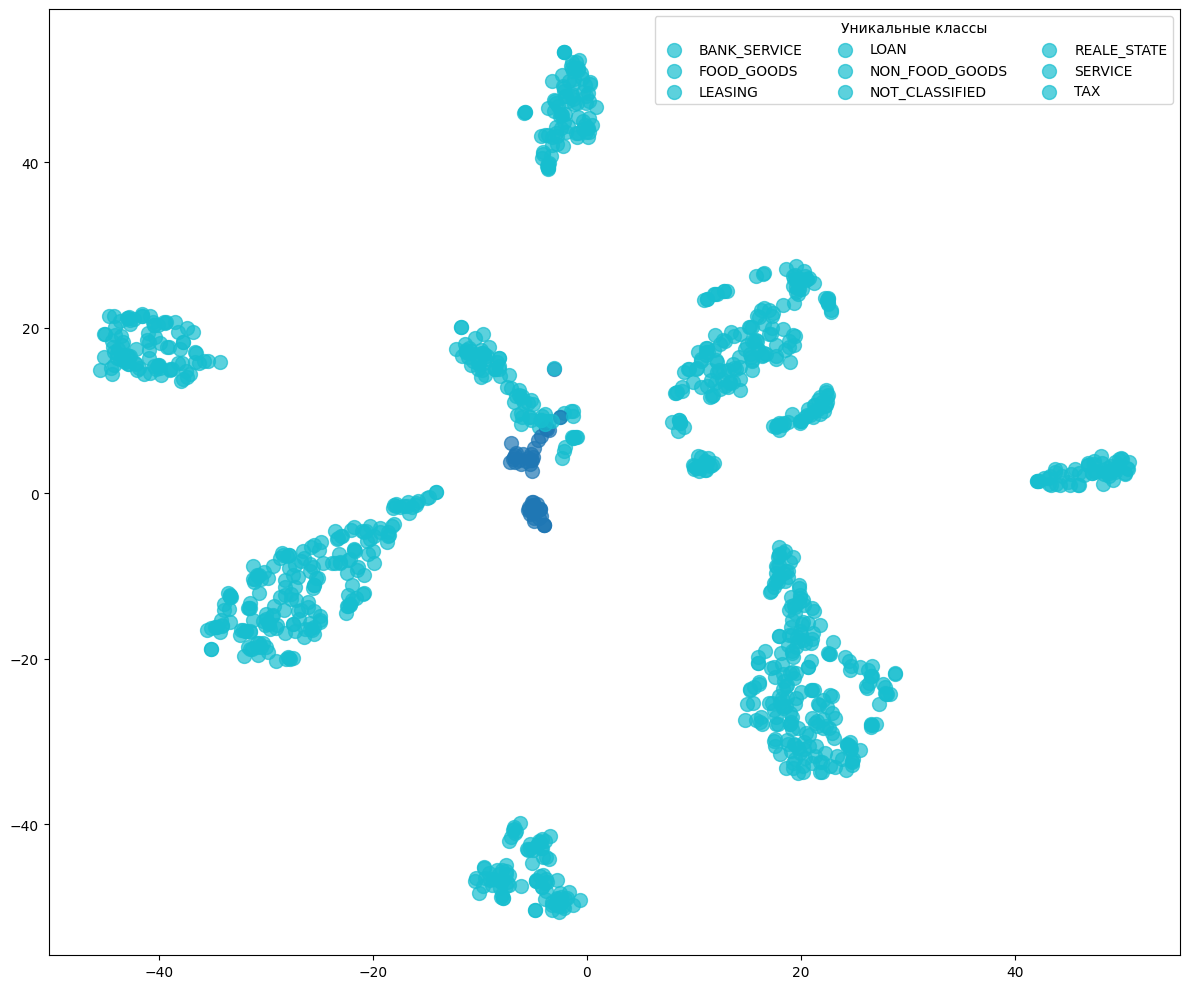

In [198]:
import matplotlib.pyplot as plt

colors = ['red', 'green', 'blue', 'yellow', 'purple', 'black', 'brown', 'pink', 'orange']
color_map = dict(zip(range(len(colors)), colors))  # Словарь для быстрого доступа к цветам

# Функция для определения цвета по номеру класса
def get_color(class_num):
    return plt.cm.tab10(class_num)  # Используем gray в качестве запасного цвета

# Создаем график
plt.figure(figsize=(12, 10))

# Отображаем точки с разными цветами
for i in range(len(compr_embs)):
    class_label = id2label[all_labels[i]]
    plt.scatter(compr_embs[i, 0], compr_embs[i, 1],
                c=get_color(all_labels[i]),
                label=f'{class_label} (ID: {id2label[all_labels[i]]})',
                s=100,  # Увеличиваем размер точек для лучшей видимости
                alpha=0.7)  # Уменьшаем прозрачность точек

# Создаем список уникальных классов
unique_classes = sorted(set(list(id2label.values())))

# Настройка легенды
plt.legend(unique_classes,
           title="Уникальные классы",
          #  loc='righ left',
          #  bbox_to_anchor=(1, 0.5),
           ncol=3)  # Размещаем легенду справа и разбиваем на три столбца

# Добавляем границы вокруг графика
plt.tight_layout()

# Отображаем график
plt.show()


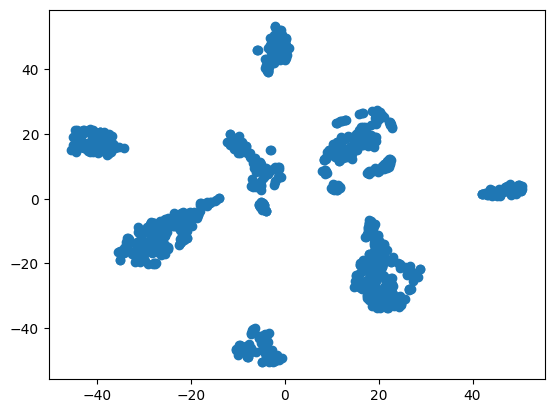

In [ ]:
plt.scatter(compr_embs[:, 0], compr_embs[:, 1])

In [ ]:
train_dataloader.batch_size

In [ ]:
all_embeds.shape

(343200,)

In [ ]:
343200 / (18 * 64)

297.9166666666667